In [1]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
df = pd.read_csv("src/data/data.csv", skip_blank_lines=True)
print(df.shape)
df.info()

C:\Users\vigne\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,3,6,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(289841, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289841 entries, 0 to 289840
Data columns (total 24 columns):
Unnamed: 0    289841 non-null int64
C_YEAR        289841 non-null int64
C_MNTH        289841 non-null object
C_WDAY        289841 non-null object
C_HOUR        289841 non-null object
C_SEV         289841 non-null int64
C_VEHS        289841 non-null object
C_CONF        289841 non-null object
C_RCFG        289841 non-null object
C_WTHR        289841 non-null object
C_RSUR        289841 non-null object
C_RALN        289841 non-null object
C_TRAF        289841 non-null object
V_ID          289841 non-null object
V_TYPE        289841 non-null object
V_YEAR        289841 non-null object
P_ID          289841 non-null object
P_SEX         289841 non-null object
P_AGE         289841 non-null object
P_PSN         289841 non-null object
P_ISEV        289841 non-null object
P_SAFE        289841 non-null object
P_USER        289841 non-null object
C_CASE        289841 non-nul

In [32]:
#Dropping all the column wherein the medical services information isn't available.
df = df[df.P_ISEV != 'U']

#Splitting test and train data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'P_ISEV') , 
                                                    df['P_ISEV'], 
                                                    test_size=0.2, 
                                                    random_state=100)

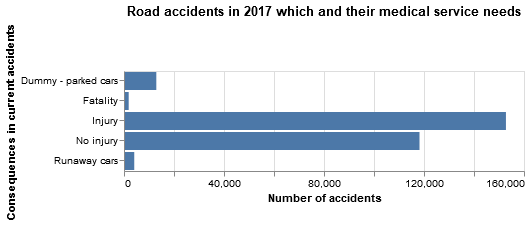

In [27]:
ncdb = pd.concat(X_train, y_train, axis = 1)

medical_encoding = {'1' : 'No injury',
                    '2' : 'Injury',
                    '3' : 'Fatality',
                    'N' : 'Dummy - parked cars',
                    'U' : 'Runaway cars',
                    'X' : 'Jurisdiction does not provide data'}
                    
ncdb['P_ISEV_tr'] = ncdb['P_ISEV'].map(medical_encoding)

med_service = list(ncdb['P_ISEV_tr'].unique())
med_service

q_0 = ncdb.groupby('P_ISEV_tr').agg({'C_CASE' : 'count'}).reset_index()

alt.Chart(q_0).mark_bar().encode(
    alt.Y('P_ISEV_tr:O', 
          title = "Consequences in current accidents", 
          sort = alt.EncodingSortField(order = "ascending")),
    alt.X('C_CASE:Q', 
          title = "Number of accidents")     
         ).properties(title = "Road accidents in 2017 which and their medical service needs")

In [21]:

medical_encoding = {'1' : 0,
            '2' : 1,
            '3' : 1,
            'N' : 0,
            'U' : 0,
            'X' : 'Jurisdiction does not provide data'}
                    
ncdb['P_ISEV_tr'] = ncdb['P_ISEV'].map(medical_encoding)

med_service = list(ncdb['P_ISEV_tr'].unique())
med_service

q_0 = ncdb.groupby('P_ISEV_tr').agg({'C_CASE' : 'count'}).reset_index()

alt.Chart(q_0).mark_bar().encode(
    alt.Y('P_ISEV_tr:O', 
          title = "Medical services", 
          sort = alt.EncodingSortField(order = "ascending")),
    alt.X('C_CASE:Q', 
          title = "Number of accidents")     
         ).properties(title = "Road accidents in 2017 which and their medical service needs")


[1, 0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
### Question_1 (descriptive) ###
# Which day of the week do most accidents occur?

#Coercing all weekday values into string
ncdb['C_WDAY'] = ncdb['C_WDAY'].astype('str')

#Removing the 22 'U' or unknown days of the cases.
ncdb = ncdb[ncdb.C_WDAY != 'U']

#What are the days information?
wday = list(ncdb['C_WDAY'].unique())
print("- The following are the days info : ", len(wday), wday, "\n")

day_week = {'1' : 'Monday',
            '2' : 'Tuesday',
            '3' : 'Wednesday',
            '4' : 'Thursday',
            '5' : 'Friday',
            '6' : 'Saturday',
            '7' : 'Sunday'}
ncdb['C_WDAY_STR'] = ncdb['C_WDAY'].map(day_week)

ncdb['C_WDAY_STR'] = pd.Categorical(ncdb['C_WDAY_STR'], ["Monday", 
                                                        "Tuesday", 
                                                        "Wednesday", 
                                                        "Thursday",
                                                        "Friday",
                                                        "Saturday",
                                                        "Sunday"])

#Grouping by weekday and aggregating by number of accidents
q1 = ncdb.groupby('C_WDAY_STR').agg({'C_CASE' : 'count'}).reset_index()

alt.Chart(q1).mark_bar().encode(
    alt.Y('C_WDAY_STR:O', 
          title = "Days of the week", 
          sort = alt.EncodingSortField(order = "ascending")),
    alt.X('C_CASE:Q', 
          title = "Number of accidents")     
         ).properties(title = "Road accidents in 2017 by day of the week")

In [ ]:
### Question_2
#Which time of the day do most accidents occur?

list(ncdb['C_HOUR'].unique())

#Padding the hour so that they are in the 01, 02 ... format
ncdb['C_HOUR'] = ncdb.C_HOUR.str.pad(2,side = 'left', fillchar = '0')

#Grouping by the hour and aggregating the count of collissions.
q2 = ncdb.groupby('C_HOUR').agg({'C_CASE' : 'count'}).reset_index()
q2 = q2.sort_values(by = 'C_HOUR')

In [ ]:
### Question_3
#Which weather conditions contribute to most accidents?


list(ncdb['C_RSUR'].unique())
weather_conversion = {'1' : 'Dry/normal',
            '2' : 'Wet',
            '3' : 'Fresh snow',
            '4' : 'Slush ,wet snow',
            '5' : 'Icy',
            '6' : 'Sand/gravel/dirt',
            '7' : 'Muddy',
            '8' : 'Oil',
            '9' : 'Flood',
            'Q' : 'Unknown',
            'U' : 'Unknown',
            'X' : 'Unknown'
                     }
ncdb['C_RSUR_STR'] = ncdb['C_RSUR'].map(weather_conversion)
list(ncdb['C_RSUR_STR'].unique())

q3 = ncdb.groupby('C_RSUR_STR').agg({'C_CASE' : 'count'}).reset_index()